# Appendix - HW 4 Szymon Sadkowski

### 1. Recreate models from HW1

In [45]:
SEED = 42
TEST_SIZE = 0.2

In [46]:
from sklearn.datasets import fetch_openml

X, Y = fetch_openml('kc1', return_X_y=True)

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


## Data split and testing models.

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


models_dict = {
    'logistic_regression': LogisticRegression(random_state=SEED, max_iter=1000, n_jobs=-1),
    'random_forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'xgboost': XGBClassifier(random_state=SEED, n_jobs=-1),
}

scaler_dict = {
    'logistic_regression': StandardScaler(),
    'random_forest': StandardScaler(),
    'xgboost': StandardScaler(),
}


In [48]:
from typing import Tuple
import numpy as np


def prep_data(model_name, x, y) -> Tuple[np.ndarray, np.ndarray]:
    y_trans = LabelEncoder()
    y = y_trans.fit_transform(y)

    x_trans = scaler_dict[model_name]
    x = x_trans.fit_transform(x)

    return x, y

In [49]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV



def train_model(model_name):
    x, y = prep_data(model_name, X, Y)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
    model = models_dict[model_name]
    grid_search = GridSearchCV(model, {}, scoring='roc_auc', cv=cv, n_jobs=-1)
    grid_search.fit(x, y)
    model = grid_search.best_estimator_
    print(f"Model: {model_name}, performance: {grid_search.best_score_}")
    return model


In [50]:
models = dict()

for model_name in reversed(models_dict.keys()):
    models[model_name] = train_model(model_name)

Model: xgboost, performance: 0.7886413672616581
Model: random_forest, performance: 0.8260059891272715
Model: logistic_regression, performance: 0.8023506731206665


### 2. Select two observations from the dataset and calculate the model's prediction.

In [51]:
np.random.seed(SEED)
rand_obs_idx = np.random.randint(0, X.shape[0], size=30)

### 3. Next, for the same observations, calculate the decomposition of predictions, so-called variable attributions, using SHAP from two packages of choice, e.g. for Python: `dalex` and `shap`, for R: `DALEX` and `iml`.

In [52]:
def xgb_predict(model, data):
    return model.predict_proba(data.to_numpy())[:, 1]

In [53]:
import dalex as dx
import pandas as pd


trans_x, trans_y = prep_data("xgboost", X, Y)
trans_x = pd.DataFrame(trans_x, columns=X.columns)
trans_y = pd.DataFrame(trans_y, columns=["prediction"])


explainer = dx.Explainer(models["xgboost"], trans_x, trans_y, predict_function=xgb_predict, label="xgb")

Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2109 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgb
  -> predict function  : <function xgb_predict at 0x7fc168034040> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000667, mean = 0.155, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.584, mean = -4.81e-05, max = 0.981
  -> model_info        : package xgboost

A new explainer has been created!


In [54]:
xgb_predict(models["xgboost"], trans_x.iloc[rand_obs_idx[[0, 1]]])

array([0.02337096, 0.06738389], dtype=float32)

In [55]:
shap_attributions = [explainer.predict_parts(trans_x.iloc[[i]], type="shap", label=f'observation {i}') for i in range(rand_obs_idx.shape[0])]

In [56]:
shap_attributions[0].plot(shap_attributions[1])

### 4. Find any two observations in the dataset, such that they have different variables of the highest importance, e.g. age and gender have the highest (absolute) attribution for observation A, but race and class are more important for observation B.

In [57]:
# datapoints 860, 1294 have different most importand attrs
X.iloc[rand_obs_idx[[0, 1]]]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
860,3.0,1.0,1.0,1.0,1.0,0.00,0.0,0.00,0.00,0.00,...,0.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1294,23.0,3.0,1.0,3.0,63.0,276.72,0.1,10.45,26.47,2892.94,...,160.72,18.0,3.0,0.0,0.0,10.0,11.0,40.0,23.0,5.0


### 5. (If possible) Select one variable X and find two observations in the dataset such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution.

### ANS: I could not find such cases when analyzing random 30 explanations

### 6. (How) Do the results differ across the two packages selected in point (3)?

In [58]:
import shap

shap_explainer = shap.explainers.Tree(models["xgboost"], data=trans_x, model_output="probability")


[23:45:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [59]:
shap_values = shap_explainer(trans_x.iloc[rand_obs_idx[[0, 1]]])


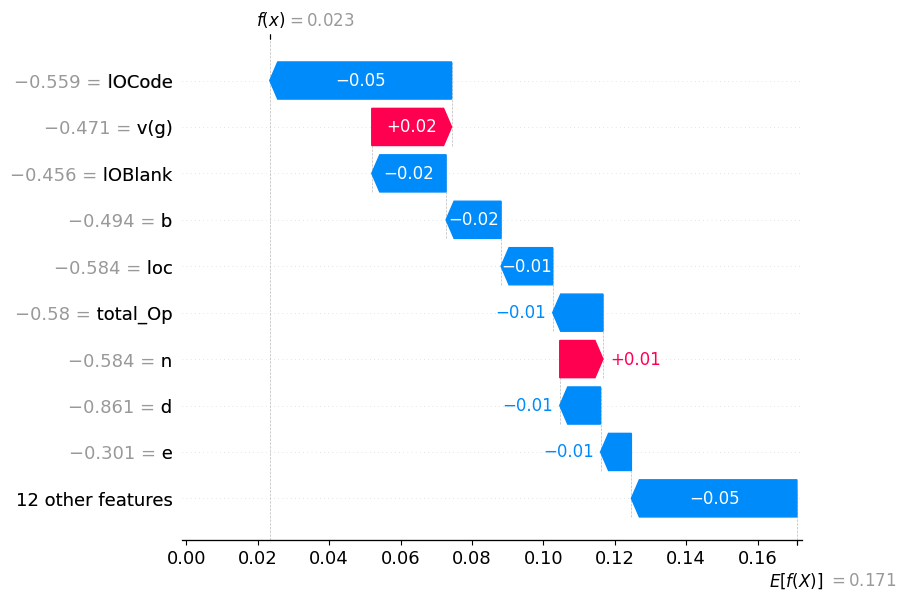

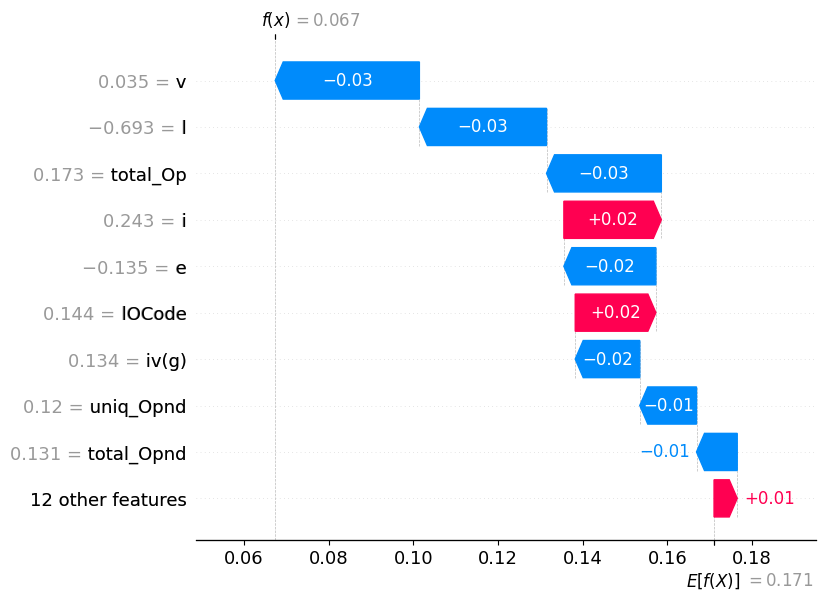

In [60]:
for i in range(2):
    shap.plots.waterfall(shap_values[i])

Plots look completly different

### 7. (Using one explanation package of choice) Train another model of any class: neural network, linear model, decision tree etc. and find an observation for which SHAP attributions are different between this model and the one trained in point (1)

In [61]:
explainer_lin = dx.Explainer(models["logistic_regression"], trans_x, trans_y, predict_function=xgb_predict, label="xgb")

Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2109 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : xgb
  -> predict function  : <function xgb_predict at 0x7fc168034040> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00345, mean = 0.155, max = 0.988
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.828, mean = 1.73e-06, max = 0.979
  -> model_info        : package sklearn

A new explainer has been created!


In [62]:
shap_attributions_lin = [explainer_lin.predict_parts(trans_x.iloc[[i]], type="shap", label=f'observation {i}') for i in range(rand_obs_idx.shape[0])]

In [63]:
shap_attributions_lin[0].plot()

In [64]:
X.iloc[[rand_obs_idx[0]]]

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
860,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


### Linear regression shap explanation look much different for datapoint above. In Linear regression most important feature is 'b' and for xgboost 'i'